### Importing Libraries.

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchsummary import summary
from tqdm import tqdm

### Downloading the datasets.

In [7]:
# Downloading CIFAR10 dataset.
train_data = CIFAR10('mnist', train = True, download = True, transform=ToTensor())
test_data  = CIFAR10('mnist', train = False, download = True, transform = ToTensor())


Files already downloaded and verified
Files already downloaded and verified


### Checking an image.

6


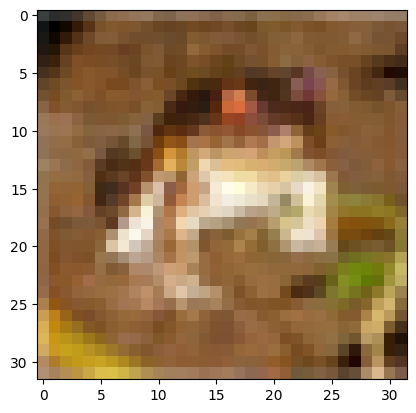

In [8]:
# Image label pairs.
print(train_data[0][1])
plt.imshow(train_data[0][0].permute(1,2,0))
plt.show()

### Creating a task set from the context and target points.

In [9]:
def get_context_target_sets(images_data, no_of_context_target_points,Image_shape):
    m,n = Image_shape

    # All coordinates of the image.
    All_coordinates = np.array([(i,j) for i in range (m) for j in range (n)])
    
    # Iterate on dataset to create context set and target set.
    task_set =  []
    for i in tqdm(range(len(images_data))):

        image, _ = images_data[i]
        #image = image.squeeze()
        # Context point indexes
        context_idx = np.random.choice(range(len(All_coordinates)), no_of_context_target_points, replace = False)

        # Context points and corresponding pixel values.
        context_points = All_coordinates[context_idx]
        image = image.permute(1, 2, 0)
        context_pixels = image[context_points[:,0], context_points[:,1]]

        # Concatenating context points and corresponding pixel values.
        context_set = np.concatenate([context_points, context_pixels],axis=-1).astype(np.float32)

        # Giving pixel values for all pixels in image to predcit all the points given on grid .
        target_points = All_coordinates
        target_pixels = image[target_points[:,0], target_points[:,1]]
        
        # concatenate target points and corresponding pixel values.
        target_set = np.concatenate([target_points, target_pixels], axis = -1).astype(np.float32)
        task_set.append([context_set,target_set])
        
    return task_set

### Generating the train set.

In [10]:
train_set = get_context_target_sets(images_data=train_data, no_of_context_target_points=300, Image_shape=(32,32))
train_dataloader = DataLoader(train_set, batch_size=32, shuffle= True)
for context_pairs, target_pairs in train_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 50000/50000 [00:12<00:00, 3913.84it/s]

torch.Size([32, 300, 5]) torch.Size([32, 1024, 5])


### Generating the test set.

In [11]:
test_set = get_context_target_sets(images_data=test_data, no_of_context_target_points=300, Image_shape=(32,32))
test_dataloader = DataLoader(test_set, batch_size=32, shuffle= True)
for context_pairs, target_pairs in test_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 10000/10000 [00:01<00:00, 7402.81it/s]

torch.Size([32, 300, 5]) torch.Size([32, 1024, 5])


### Creating the Neural Process Class and defining the forward propagation, train and test functions.

In [12]:
class Neural_process_model(nn.Module):
    def __init__(self, device):
        super(Neural_process_model, self).__init__()
        if device == 'cuda':
            if torch.cuda.is_available():
                device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        self.device = device
        
        self.encoder = nn.Sequential(
                                    nn.Linear(5,64),
                                    nn.ReLU(),
                                    nn.Linear(64,128),
                                    nn.ReLU(),
                                    nn.Linear(128,256)
                                    )
        self.decoder = nn.Sequential(
                                    nn.Linear(256+2, 128),
                                    nn.ReLU(),
                                    nn.Linear(128,64),
                                    nn.ReLU(),
                                    nn.Linear(64,32),
                                    nn.ReLU(),
                                    nn.Linear(32,3)
                                    )
        
    def forward(self, context_pairs, target_pairs):
        latent_representation = self.encoder(context_pairs)
        # print(latent_representation)
        latent_representation = torch.mean(latent_representation, dim = 1)
        latent_representation = latent_representation.unsqueeze(1).repeat(1, target_pairs.size(1),1)

        # Cocatenating latent representation with target pixel locations.
        target_pixel_locations = target_pairs[:,:,:2]
        target = torch.cat([latent_representation, target_pixel_locations], dim = -1)

        # decode target pairs to obtain the predicted target pixel intensity
        predicted_target_pixel_intensity = self.decoder(target)
        
        return predicted_target_pixel_intensity
    
    def train(self, train_dataloader, num_epochs =100, optim = torch.optim.Adam, lr = 3e-4, criterion = nn.MSELoss(), verbose = True):
        device = self.device
        optimiser = optim(self.parameters(), lr = lr)
        for epoch in range(num_epochs):
            for _, (context_pairs, target_pairs) in enumerate(train_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                optimiser.zero_grad()
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)
                loss = criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
                loss.backward()
                optimiser.step()
            if verbose:
                print("Epoch: {}/{} Loss: {:.5f}".format(epoch+1,num_epochs,loss.item()))

    def test(self, test_dataloader, criterion = nn.MSELoss()):
        device = self.device
        self.to(device)
        test_loss = 0
        with torch.no_grad():
            for i, context_pairs, target_pairs, in enumerate(test_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)

            loss =  criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
            test_loss += loss.item()
        print(f'Test Loss: {test_loss/len(test_dataloader)}')

### Checking the avialable device.

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Training the model.

In [ ]:
model = Neural_process_model(device = device)
model.train(train_dataloader, num_epochs=100)

Epoch: 1/100 Loss: 0.04275
Epoch: 2/100 Loss: 0.02938
Epoch: 3/100 Loss: 0.02660
Epoch: 4/100 Loss: 0.02781
Epoch: 5/100 Loss: 0.02836
Epoch: 6/100 Loss: 0.02484
Epoch: 7/100 Loss: 0.02634
Epoch: 8/100 Loss: 0.02627
Epoch: 9/100 Loss: 0.02262
Epoch: 10/100 Loss: 0.03007
Epoch: 11/100 Loss: 0.02575
Epoch: 12/100 Loss: 0.02508
Epoch: 13/100 Loss: 0.02186
Epoch: 14/100 Loss: 0.02258
Epoch: 15/100 Loss: 0.01854
Epoch: 16/100 Loss: 0.02259
Epoch: 17/100 Loss: 0.02178
Epoch: 18/100 Loss: 0.02389
Epoch: 19/100 Loss: 0.01996
Epoch: 20/100 Loss: 0.01985
Epoch: 21/100 Loss: 0.01950
Epoch: 22/100 Loss: 0.02004
Epoch: 23/100 Loss: 0.01890
Epoch: 24/100 Loss: 0.02264
Epoch: 25/100 Loss: 0.01782
Epoch: 26/100 Loss: 0.01689
Epoch: 27/100 Loss: 0.01879
Epoch: 28/100 Loss: 0.02290
Epoch: 29/100 Loss: 0.01948
Epoch: 30/100 Loss: 0.01493
Epoch: 31/100 Loss: 0.02337
Epoch: 32/100 Loss: 0.02147
Epoch: 33/100 Loss: 0.01768
Epoch: 34/100 Loss: 0.02086
Epoch: 35/100 Loss: 0.02045
Epoch: 36/100 Loss: 0.01581
E

### Testing the Neural Process.

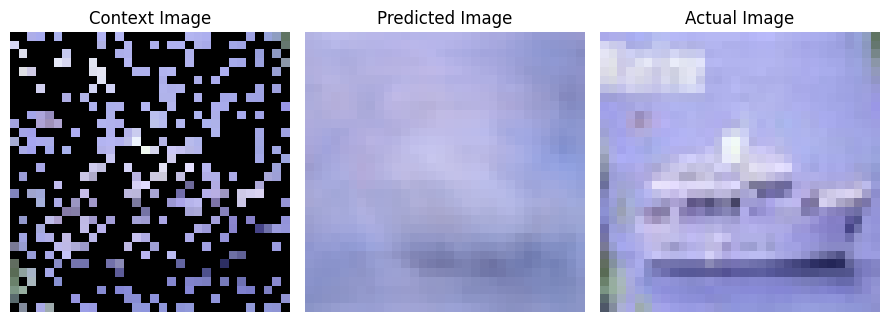

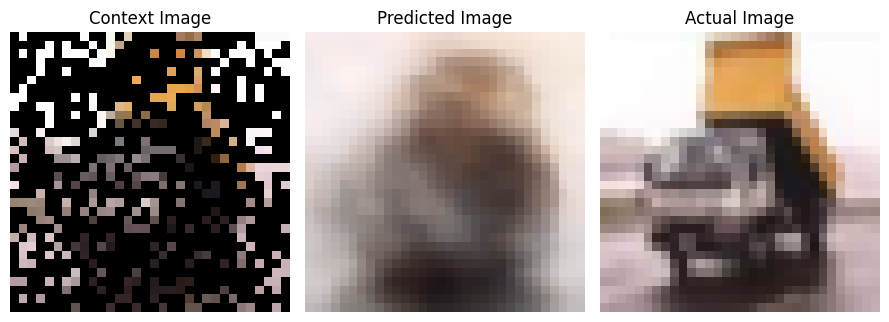

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035688125..0.85007495].


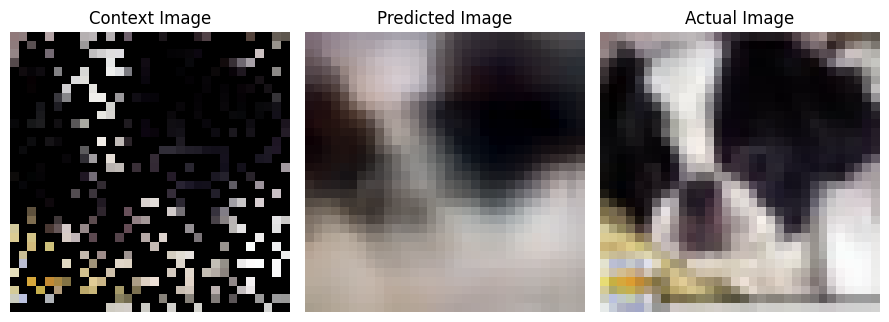

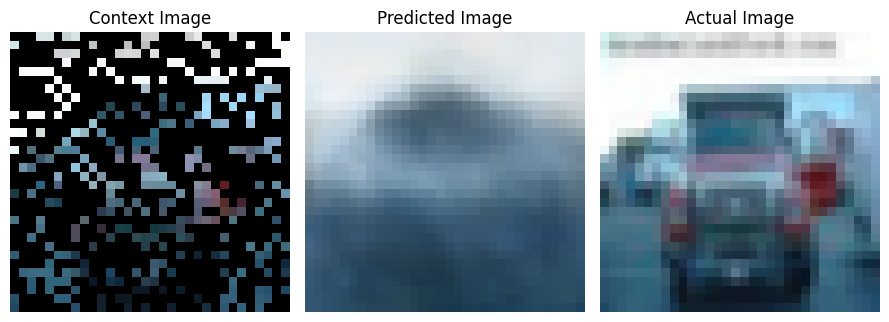

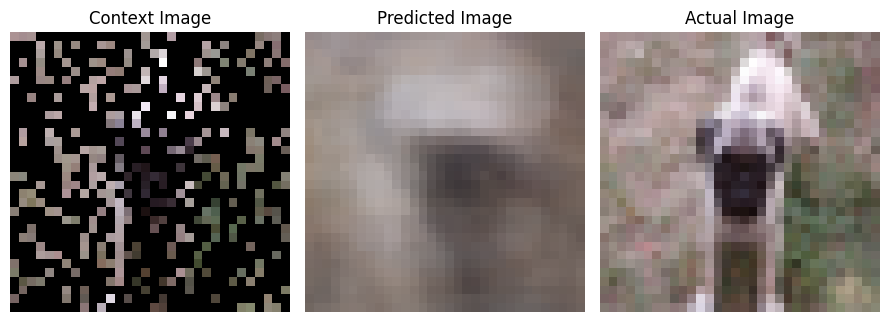

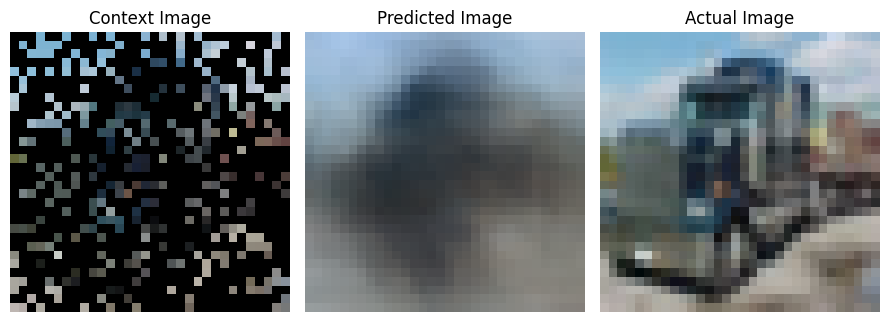

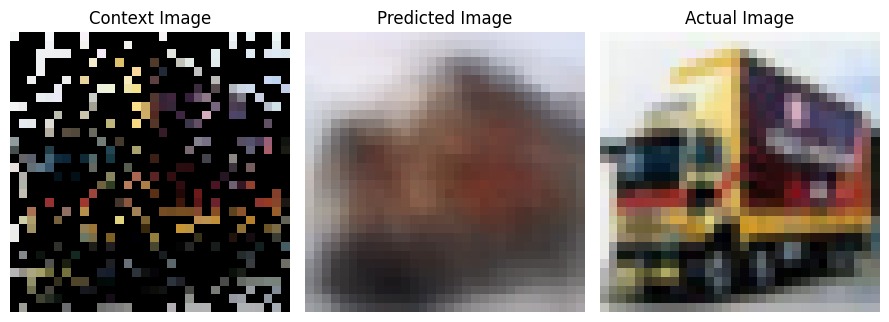

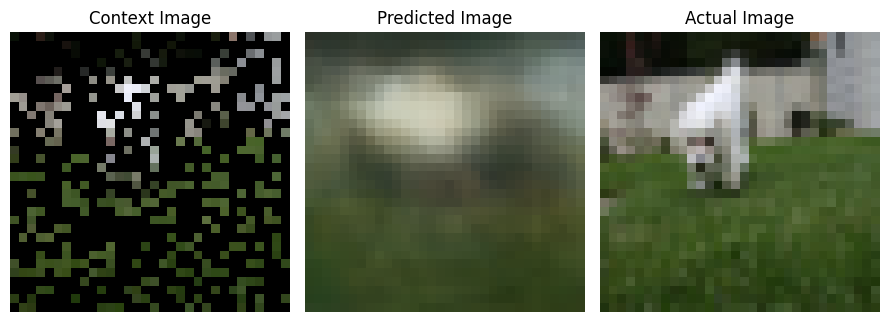

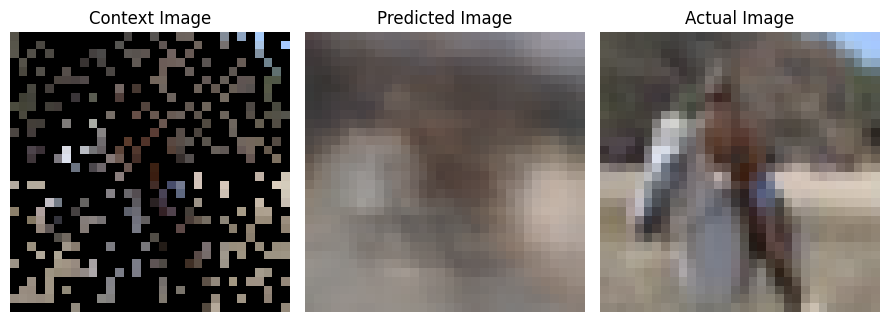

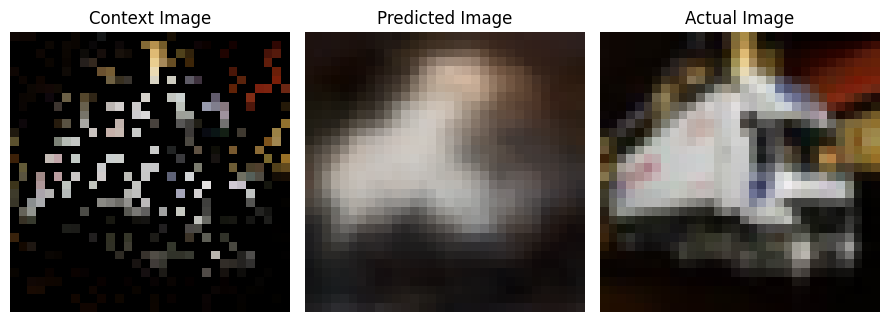

In [91]:
# testing the neural process.
for context_pairs, target_pairs in test_dataloader:
    context_pairs = context_pairs.to(device)
    target_pairs  = target_pairs.to(device)
    model.to(device)

    predicted_target_pixel_intensity = model(context_pairs, target_pairs)
    for i in range(10):
        predicted_pixel = predicted_target_pixel_intensity[i].detach().cpu().numpy()
        predicted_image = predicted_pixel.reshape(32,32,3)

        actual_pixel = target_pairs[i][:,2:].detach().cpu().numpy()
        actual_image = actual_pixel.reshape(32,32,3)

        context_image = np.zeros((32,32,3))
        context_pixel_locations = context_pairs[i][:,:2].detach().cpu().numpy().astype(int)
        context_image[context_pixel_locations[:,0], context_pixel_locations[:,1]] = context_pairs[i][:,2:].detach().cpu().numpy()

        plt.figure(figsize=(9,4))

        plt.subplot(1,3,1)
        plt.imshow(context_image)
        plt.axis('off')
        plt.title('Context Image')
        
        plt.subplot(1,3,2)
        plt.imshow(predicted_image)
        plt.axis('off')
        plt.title('Predicted Image')

        plt.subplot(1,3,3)
        plt.imshow(actual_image)
        plt.axis('off')
        plt.title('Actual Image')
        
        plt.tight_layout()
        plt.show()

    break